<a href="https://colab.research.google.com/github/Shrey-Viradiya/ML_for_Finance/blob/master/ML4fin_section_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d mlg-ulb/creditcardfraud
! unzip creditcardfraud.zip

 65% 43.0M/66.0M [00:00<00:00, 66.6MB/s]
100% 66.0M/66.0M [00:00<00:00, 104MB/s] 
Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import warnings
# warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
np.random.seed(259)
%matplotlib inline


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

## 7.3 Feature engineering and preprocess data for input into the model

### Import the data

In [4]:
credit_df = pd.read_csv("./creditcard.csv")

In [5]:
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:
credit_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
credit_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [8]:
credit_df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

Scale the features so as to mitigate the biasness towards one feature

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [10]:
X = credit_df.iloc[:,:-1]
Y = credit_df.iloc[:,-1]
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2,random_state=100, stratify=Y)

In [11]:
Y_train.value_counts()

0    227451
1       394
Name: Class, dtype: int64

In [12]:
Y_test.value_counts()

0    56864
1       98
Name: Class, dtype: int64

In [13]:
mmscale = MinMaxScaler()
mmscale.fit(X_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [14]:
X_train = mmscale.transform(X_train)

In [15]:
X_test = mmscale.transform(X_test)

### 7.4 Create the model and the optimizer

In [16]:
def get_model():
    model = Sequential()
    model.add(Dense(30,input_shape=(30,), activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    print(model.summary())
    return model

In [17]:
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# get the model
model = get_model()

# compile the model
model.compile(optimizer='RMSProp', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                930       
_________________________________________________________________
dense_1 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 80        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 1,481
Trainable params: 1,481
Non-trainable params: 0
_________________________________________________________________
None


## 7.5 - Train the model

In [18]:
# fit the model
history = model.fit(X_train, Y_train, validation_split=0.1, epochs=50, verbose=1,batch_size=1000)

# evaluate the model
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, Y_test, verbose=0)

Epoch 1/50
206/206 [==============================] - 1s 3ms/step - loss: 0.0371 - acc: 0.9983 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.0106 - val_acc: 0.9983 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/50
206/206 [==============================] - 0s 2ms/step - loss: 0.0097 - acc: 0.9983 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 0.0081 - val_acc: 0.9983 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/50
206/206 [==============================] - 0s 2ms/step - loss: 0.0071 - acc: 0.9984 - f1_m: 0.1158 - precision_m: 0.1877 - recall_m: 0.0897 - val_loss: 0.0054 - val_acc: 0.9988 - val_f1_m: 0.2710 - val_precision_m: 0.4130 - val_recall_m: 0.2261
Epoch 4/50
206/206 [==============================] - 0s 2ms/step - loss: 0.0047 - acc: 0.9989 - f1_m: 0.4050 - precision_m: 0.4919 - recall_m: 0.3743 - val_loss: 0.0041 - val_acc: 0.9

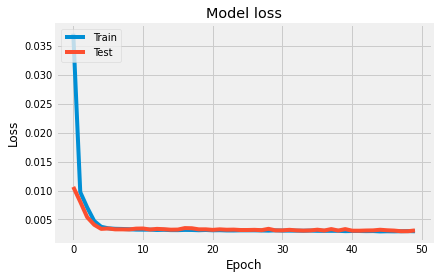

In [19]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [20]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

In [21]:
train_predictions_baseline = model.predict(X_train, batch_size=1000)
test_predictions_baseline = model.predict(X_test, batch_size=1000)

In [22]:
import sklearn
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, roc_curve

Legitimate Transactions Detected (True Negatives):  56845
Legitimate Transactions Incorrectly Detected (False Positives):  19
Fraudulent Transactions Missed (False Negatives):  23
Fraudulent Transactions Detected (True Positives):  75
Total Fraudulent Transactions:  98


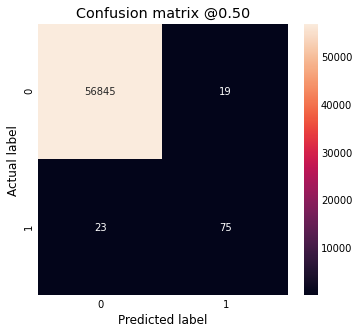

In [23]:
plot_cm(Y_test, test_predictions_baseline)

In [24]:
print(classification_report(Y_test,test_predictions_baseline>0.5))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.80      0.77      0.78        98

    accuracy                           1.00     56962
   macro avg       0.90      0.88      0.89     56962
weighted avg       1.00      1.00      1.00     56962



In [25]:
print(roc_auc_score(Y_test,test_predictions_baseline>0.5))

0.8824859959459305


## 7.6 - Handling Class Imbalance

#### Increase class weight of positive instances

In [26]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
neg, pos = np.bincount(credit_df['Class'])
total = neg + pos
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


In [27]:
weighted_model = get_model()

# compile the model
weighted_model.compile(optimizer='RMSProp', loss='binary_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])

# fit the model
history = weighted_model.fit(X_train, Y_train, validation_split=0.1, epochs=50, verbose=1,batch_size=1000, class_weight=class_weight)

# evaluate the model
loss, accuracy, f1_score, precision, recall = weighted_model.evaluate(X_test, Y_test, verbose=0)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_5 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 80        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 6         
Total params: 1,481
Trainable params: 1,481
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
206/206 [==============================] - 1s 3ms/step - loss: 0.6239 - acc: 0.9985 - f1_m: 0.2866 - precision_m: 0.3482 - recall_m: 0.2659 - val_loss: 0.3917 - val_acc: 0.9993 - val_f1_m: 0.5500 - val_precision_m: 0.6232 - val_recall

## 7.7 - Evaluate the final model and predict fraud using the model

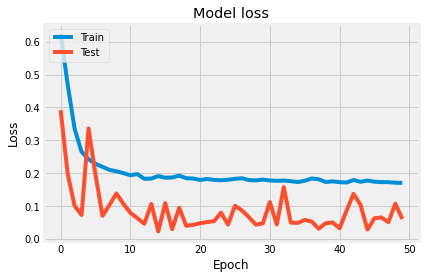

In [28]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [29]:
def find_optimal_cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]
    # Plot tpr vs 1-fpr
    fig, ax = plt.subplots()
    plt.plot(tpr)
    plt.plot(1-fpr, color = 'red')
    plt.xlabel('1-False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    ax.set_xticklabels([])
    return list(roc_t['threshold']) 

In [30]:
test_predictions_weighted = weighted_model.predict(X_test, batch_size=1000)

[0.11430588364601135]

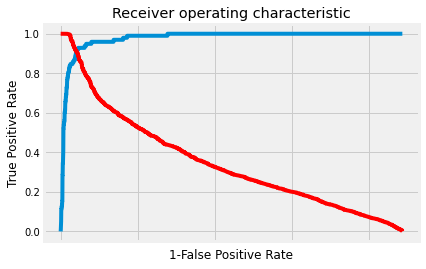

In [31]:
find_optimal_cutoff(Y_test, test_predictions_weighted)

Legitimate Transactions Detected (True Negatives):  54320
Legitimate Transactions Incorrectly Detected (False Positives):  2544
Fraudulent Transactions Missed (False Negatives):  14
Fraudulent Transactions Detected (True Positives):  84
Total Fraudulent Transactions:  98


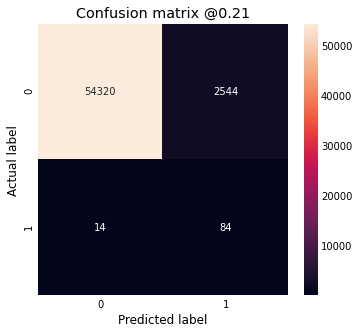

In [32]:
plot_cm(Y_test, test_predictions_weighted, p=0.21)

In [33]:
print(classification_report(Y_test, test_predictions_weighted>0.21))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.03      0.86      0.06        98

    accuracy                           0.96     56962
   macro avg       0.52      0.91      0.52     56962
weighted avg       1.00      0.96      0.98     56962



In [34]:
roc_auc_score(Y_test, test_predictions_weighted>0.21)

0.9062022670632688